<center><h1>Challenge RNN

In this challenge, the gaol is to train a classifier for sequences of genetic code.

Each sequence is represented by a string of letters [‘A’, ‘C’, ‘G’, ’T’] and belongs to one of five categories/classes labelled [0,…,4].

For training purposes, you will find 400 labelled sequences, each of length 400 characters (sequences: **data_x**, labels: **data_y**).

To validate your model, you have a further 100 labelled sequences (**val_x**, **val_y**) with 1200 characters each.

Finally, you have 250 unlabeled sequences (**test_x**, 2000 characters) which need to be classified.

Hint: Training recurrent networks is very expensive! Do not start working on this challenge too late or you might not manage to finish in time.

Your task is to train an RNN-based classifier and make a prediction for the missing labels of the test set (**test_x** in the attached archive). Store your prediction as a one-dimensional **numpy.ndarray**, save this array as **prediction.npy**, and upload this file to the whiteboard.

To load  the data and save your prediction, please refer to the following code snippet:

In [1]:
import numpy as np

with open('rnn-challenge-data.npz', 'rb') as f:
    X = np.load(f)
    data_x = X['data_x']
    data_y = X['data_y']
    val_x = X['val_x']
    val_y = X['val_y']
    test_x = X['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# VALIDATION DATA: INPUT (x) AND OUTPUT (y)
print(val_x.shape, val_x.dtype)
print(val_y.shape, val_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

(400,) <U400
(400,) int64
(100,) <U1200
(100,) int64
(250,) <U2000


In [2]:
# Printing one for having an idea
print(data_x[0])

CTAGCTGAGCTACTGAGCTACAGTTGACTGACCAGTCAGTGCTAGCTACTGACAGTCTGACAGTTGACCTGACTGATGACCAGTCTAGCAGTGCTACTAGCTAGGCTACAGTCAGTTGACCAGTCTGACAGTCAGTCTGACTGACAGTCAGTCTAGGCTATGACCTGACTGATGACCTGACTGACTGACAGTCTGACTGATGACGCTATGACCTGACTAGCTAGCAGTTGACTGACCTGACAGTGCTACTAGCAGTTGACCAGTGCTACAGTCTGATGACTGACCTGACAGTCTAGGCTACAGTTGACCTGACAGTCAGTGCTACTGACAGTCTAGTGACCAGTCAGTCAGTTGACCTGACTAGCAGTTGACGCTATGACCAGTCTGACAGTGCTACTAG


# Code
We could try
* Simple RNN
* LSTM

In [3]:
import torch
import torch.nn as nn

import time
import math

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

Here making us of this tutorial : [NLP From Scratch: Classifying Names with a Character level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) (from Pytorch)

## Preparing the data

In [4]:
n_categories = 5              # [0, 1, 2, 3, 4]

all_letters = 'ACGT'          # rather than all possible letters through 'string.ascii'
n_letters = len(all_letters)

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Testing that everything works
print(letterToTensor('A'))
print(lineToTensor('ACGTTAGC').size())

tensor([[1., 0., 0., 0.]])
torch.Size([8, 1, 4])


Turning all the data to tensors:

In [6]:
data_x_torch = torch.stack([lineToTensor(data_x[i]) for i in range(len(data_x))])
val_x_torch = torch.stack([lineToTensor(val_x[i]) for i in range(len(val_x))])
test_x_torch = torch.stack([lineToTensor(test_x[i]) for i in range(len(test_x))])

data_y_torch = torch.from_numpy(data_y)
val_y_torch = torch.from_numpy(val_y)

## Creating the model

What is `n_hidden` useful for? Is it how large is the network at its hidden layer part?

In [74]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

## Training

In [75]:
# Trying with a single letter
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-1.6499, -1.6228, -1.6302, -1.6709, -1.4845]],
       grad_fn=<LogSoftmaxBackward>)


In [76]:
# Trying with a sequence
input = data_x_torch[0] # first sequence of the training data
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.5788, -1.5087, -1.6327, -1.6571, -1.6793]],
       grad_fn=<LogSoftmaxBackward>)


In [77]:
# Helper function for classification
def categoryFromOutput(output):
    _, top_i = output.topk(1)
    return top_i[0].item()

print(categoryFromOutput(output))

1


In [78]:
criterion = nn.NLLLoss()
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

Here we try to implement now the **teacher forcing** in the training phase. Question: shall the teacher forcing be at a character level or at word level?

First we try at a character level:

In [79]:
teacher_forcing_ratio = 0.5                # 0 = always teacher forcing, 1 = no teacher forcing

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().to(device)

    rnn.zero_grad()       # Set all gradients of model to zero

    for i in range(line_tensor.size()[0]):
#         use_teacher_forcing = True if np.random.random()<0.5 else False
        
#         if use_teacher_forcing:
#             # Rewire
#         else:
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

### Using GPU if available

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device) # Assuming that we are on a CUDA machine, this should print a CUDA device:
rnn.to(device); # This sends the whole network parameters and buffers to GPU

In [81]:
# n_iters = 100000
epochs = 13
# print_every = 5000
# plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

# def timeSince(since):
#     now = time.time()
#     s = now - since
#     m = math.floor(s / 60)
#     s -= m * 60
#     return '%dm %ds' % (m, s)

# start = time.time()

# train_ds = torch.utils.data.TensorDataset(data_x_torch, data_y_torch)
# train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# for epoch in range(epochs):
    
#     output, loss = train(category_tensor, line_tensor)
#     current_loss += loss


for epoch in tqdm(range(1, epochs+1)):
    current_loss = 0
    
    # Goes through the whole dataset:
    for category, line_tensor in zip(data_y, data_x_torch):
        
        # For using GPU; doesn't seem to be speeding-up though
        input = line_tensor.to(device)
        label = torch.tensor([category]).to(device)
        
        output, loss = train(label, input)
        current_loss += loss
    
    print(f"Epoch n°{epoch}: Loss = {current_loss/400}")
    all_losses.append(current_loss / 400)
    
    # Break the loop if reached a "nan", more computing would be unnecessary
    if np.isnan(all_losses[-1]):
        print(f"Stopping at epoch n°{epoch}: loss is nan")
        break

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch n°1: Loss = 1.61437704205513
Epoch n°2: Loss = 1.6020556017756462
Epoch n°3: Loss = 1.5899737989902496
Epoch n°4: Loss = 1.577837836444378
Epoch n°5: Loss = 1.5653494307398796
Epoch n°6: Loss = 1.5521654406189918
Epoch n°7: Loss = 1.537831297814846
Epoch n°8: Loss = 1.5216340273618698
Epoch n°9: Loss = 1.5021603354811668
Epoch n°10: Loss = 1.4750711503624916
Epoch n°11: Loss = nan
Stopping at epoch n°11: loss is nan


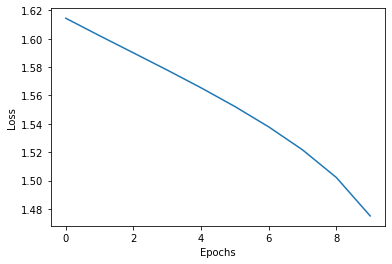

In [82]:
# Plotting the loss
plt.plot(all_losses)
plt.xlabel("Epochs");
plt.ylabel("Loss");

# Validation

We want to see what is our score on the validation set **val_x** with **val_y**.

In [61]:
# Trying to produce 1 prediction
i = 0
category = val_y_torch[i]
line_tensor = val_x_torch[i]

input = val_x_torch[0].to(device) # first sequence of the training data
hidden = torch.zeros(1, n_hidden).to(device)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(f"Label for this data: {category}")

tensor([[nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
Label for this data: 4


In [ ]:
# Then trying to loop and produce all submission for giving a score:
for ... in ...:
    
print(f"Score over validation dataset: {score:.3f}%")

# Prediction and submission

In [ ]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 250

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (250, )
    assert loaded.dtype == int
    assert (loaded <= 4).all()
    assert (loaded >= 0).all()
validate_prediction_format()

**accuracy** → **points**<br>
≥95% → 10<br>
≥90% → 7<br>
≥85% → 5